# Import Liberaries

In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install virtualenv

In [ ]:
# !virtualenv /content/drive/MyDrive/colab_env

In [2]:
# !source /content/drive/MyDrive/colab_env/bin/activate; pip install netCDF4 geopandas pyet rasterio wxee geemap rioxarray rasterio virtualenv
!source /content/drive/MyDrive/colab_env/bin/activate

In [3]:
import os
import sys
sys.path.append("/content/drive/MyDrive/colab_env/lib/python3.10/site-packages")
import pandas as pd
import numpy as np
import netCDF4 as nc
import xarray as xr
import geopandas as gpd
import pyet
import pickle
import pyproj
import ee
import wxee
import geemap
import itertools
import rasterio
from osgeo import gdal

# sys.path.append('/home/mahdi/WaterBalance/')

sys.path.append('/content/drive/MyDrive/WaterBalance_new')

from qdwb.evapotranspiration.et import *
from qdwb.evapotranspiration.asset import *
from qdwb.evapotranspiration.convert import *
from qdwb.coordinate.extract import *

# Varables

In [4]:
PATH_DATA = "/content/drive/MyDrive/WaterBalance_new/assets"

# mashhad
LAT_MIN = 35.80
LAT_MAX = 37.11
LON_MIN = 58.31
LON_MAX = 60.14

# USA
# LAT_MIN = 43.30
# LAT_MAX = 44.60
# LON_MIN = -109.40
# LON_MAX = -107.40


# Functions

In [5]:
def mask_nc_file(
    nc,
    variable,
    lat_min,
    lat_max,
    lon_min,
    lon_max
):
    with xr.open_dataset(nc) as xr_nc:
        result = xr_nc.sel(
            lat = slice(lat_max, lat_min),
            lon = slice(lon_min, lon_max),
        )
    return result


def relative_humidity(
    temperature,
    pressure,
    specific_humidity
):
    """
        Description
        -----------
        Estimate relative_humidity from temperature, pressure and specific_humidity.
        
        Parameters
        ----------
        
        temperature : float
            temperature [K].
        
        reference_temperature : float
            reference_temperature [K] - typically 273.16 K
            
        pressure : float
            pressure [Pa]
        
        specific_humidity : float
            specific_humidity [dimensionless].
            
        Returns
        -------
        relative_humidity : float
            relative_humidity [dimensionless]
    """
    temp_1 = (17.67 * (temperature - 273.16)) / (temperature - 29.65)
    temp_2 = 0.263 * pressure * specific_humidity
    
    return temp_2 / (np.exp(temp_1))


# Load Data

In [6]:
# degree_Celsius - Max air temperature
tmax = mask_nc_file(
    nc = PATH_DATA + "/nc/Tmax_2022031.nc",
    variable = "air_temperature",
    lat_min = LAT_MIN,
    lat_max = LAT_MAX,
    lon_min = LON_MIN,
    lon_max = LON_MAX
)
# degree_Celsius - Min air temperature
tmin = mask_nc_file(
    nc = PATH_DATA + "/nc/Tmin_2022031.nc",
    variable = "air_temperature",
    lat_min = LAT_MIN,
    lat_max = LAT_MAX,
    lon_min = LON_MIN,
    lon_max = LON_MAX
)
# degree_Celsius - Mean air temperature
tmean = mask_nc_file(
    nc = PATH_DATA + "/nc/Temp_2022031.nc",
    variable = "air_temperature",
    lat_min = LAT_MIN,
    lat_max = LAT_MAX,
    lon_min = LON_MIN,
    lon_max = LON_MAX
)
# m s-1 - wind_speed
wind = mask_nc_file(
    nc = PATH_DATA + "/nc/wind_2022031.nc",
    variable = "wind_speed",
    lat_min = LAT_MIN,
    lat_max = LAT_MAX,
    lon_min = LON_MIN,
    lon_max = LON_MAX
)
# W m-2 - downward_shortwave_radiation
Rns = mask_nc_file(
    nc = PATH_DATA + "/nc/SWd_2022031.nc",
    variable = "downward_shortwave_radiation",
    lat_min = LAT_MIN,
    lat_max = LAT_MAX,
    lon_min = LON_MIN,
    lon_max = LON_MAX
)
# kg kg-1 - specific_humidity
specific_humidity = mask_nc_file(
    nc = PATH_DATA + "/nc/SpecHum_2022031.nc",
    variable = "specific_humidity",
    lat_min = LAT_MIN,
    lat_max = LAT_MAX,
    lon_min = LON_MIN,
    lon_max = LON_MAX
)
# Pa - surface_pressure
surface_pressure = mask_nc_file(
    nc = PATH_DATA + "/nc/Pres_2022031.nc",
    variable = "surface_pressure",
    lat_min = LAT_MIN,
    lat_max = LAT_MAX,
    lon_min = LON_MIN,
    lon_max = LON_MAX
)
# mm d-1 - precipitation
P = mask_nc_file(
    nc = PATH_DATA + "/nc/P_2022031.nc",
    variable = "precipitation",
    lat_min = LAT_MIN,
    lat_max = LAT_MAX,
    lon_min = LON_MIN,
    lon_max = LON_MAX
)
# W m-2 - downward_longwave_radiation
Rnl = mask_nc_file(
    nc = PATH_DATA + "/nc/LWd_2022031.nc",
    variable = "downward_longwave_radiation",
    lat_min = LAT_MIN,
    lat_max = LAT_MAX,
    lon_min = LON_MIN,
    lon_max = LON_MAX
)




In [7]:
service_account = 'test-175@ee-mohammadnejadmehdi77.iam.gserviceaccount.com'

credentials = ee.ServiceAccountCredentials(
    email=service_account, 
    key_file='/content/drive/MyDrive/private-key.json'
)

ee.Initialize(credentials)

In [8]:
crs = 4326
shape = ee.Geometry.Rectangle([LON_MAX,LAT_MIN,LON_MIN,LAT_MAX])

soilmoisture = ee.ImageCollection('NASA_USDA/HSL/SMAP10KM_soil_moisture').filter(ee.Filter.date('2022-01-31T00:00:00', '2022-02-01T00:00:00')).select('ssm').mean().clip(shape)

sub_soilmoisture = ee.ImageCollection('NASA_USDA/HSL/SMAP10KM_soil_moisture').filter(ee.Filter.date('2022-01-31T00:00:00', '2022-02-01T00:00:00')).select('susm').mean().clip(shape)

soil_era_evap = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").filter(ee.Filter.date('2022-01-31', '2022-02-01')).select('volumetric_soil_water_layer_1').mean().clip(shape)

soilmoisture = soilmoisture.set("system:time_start", ee.Date("2022-01-31"))
sub_soilmoisture = sub_soilmoisture.set("system:time_start", ee.Date("2022-01-31"))
soil_era_evap_1 = soil_era_evap.set("system:time_start", ee.Date("2022-01-31"))

arr_soilmoisture = soilmoisture.wx.to_xarray(scale=10000, crs=f'EPSG:{crs}')
arr_sub_soilmoisture = sub_soilmoisture.wx.to_xarray(scale=10000, crs=f'EPSG:{crs}')
arr_soil_era_evap_1 = soil_era_evap_1.wx.to_xarray(scale=11132, crs=f'EPSG:{crs}')

da_soilmoisture = arr_soilmoisture.rio.write_crs(f"epsg:{crs}", inplace=True)
da_sub_soilmoisture = arr_sub_soilmoisture.rio.write_crs(f"epsg:{crs}", inplace=True)
da_soil_era_evap_1 = arr_soil_era_evap_1.rio.write_crs(f"epsg:{crs}", inplace=True)

tmin_renamed = tmin.rename({'lon': 'x','lat': 'y'})
tmin_renamed = tmin_renamed.rio.write_crs(f"epsg:{crs}", inplace=True)

xds_repr_match__soilmoisture = da_soilmoisture.rio.reproject_match(tmin_renamed, resampling = rasterio.enums.Resampling.nearest)
xds_repr_match__sub_soilmoisture = da_sub_soilmoisture.rio.reproject_match(tmin_renamed, resampling = rasterio.enums.Resampling.nearest)
xds_repr_match__soil_era_evap_1 = da_soil_era_evap_1.rio.reproject_match(tmin_renamed, resampling = rasterio.enums.Resampling.nearest)


xds_repr_match__soil_era_evap_1 = xds_repr_match__soil_era_evap_1 * 70
xds_repr_match__soil_era_evap_1

Downloading:   0%|          | 0.00/1.86k [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/1.88k [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/2.38k [00:00<?, ?iB/s]

<xarray.Dataset>
Dimensions:                        (x: 18, y: 13, time: 1)
Coordinates:
  * x                              (x) float32 58.35 58.45 58.55 ... 59.95 60.05
  * y                              (y) float32 37.05 36.95 36.85 ... 35.95 35.85
  * time                           (time) datetime64[ns] 2022-01-31
    spatial_ref                    int64 0
Data variables:
    volumetric_soil_water_layer_1  (time, y, x) float64 21.95 22.47 ... 8.413
Attributes:
    transform:               (0.10000045742818513, 0.0, 58.30026668063193, 0....
    res:                     (0.10000045742818513, 0.10000045742818513)
    is_tiled:                1
    nodatavals:              (-32768.0,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

# Estimate persent of soil properties like sand, clay and organic

In [9]:
# Soil depths [in cm] where we have data.
olm_depths = [0, 10, 30, 60, 100, 200]

# Names of bands associated with reference depths.
olm_bands = ["b" + str(sd) for sd in olm_depths]

def get_soil_prop(param):
    """
    This function returns soil properties image
    param (str): must be one of:
        "sand"     - Sand fraction
        "clay"     - Clay fraction
        "orgc"     - Organic Carbon fraction
    """
    if param == "sand":  # Sand fraction [%w]
        snippet = "OpenLandMap/SOL/SOL_SAND-WFRACTION_USDA-3A1A1A_M/v02"
        # Define the scale factor in accordance with the dataset description.
        scale_factor = 1 * 0.01

    elif param == "clay":  # Clay fraction [%w]
        snippet = "OpenLandMap/SOL/SOL_CLAY-WFRACTION_USDA-3A1A1A_M/v02"
        # Define the scale factor in accordance with the dataset description.
        scale_factor = 1 * 0.01

    elif param == "orgc":  # Organic Carbon fraction [g/kg]
        snippet = "OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02"
        # Define the scale factor in accordance with the dataset description.
        scale_factor = 5 * 0.001  # to get kg/kg
    else:
        return print("error")

    # Apply the scale factor to the ee.Image.
    dataset = ee.Image(snippet).multiply(scale_factor)

    return dataset


# Image associated with the sand content.
sand = get_soil_prop("sand")

# Image associated with the clay content.
clay = get_soil_prop("clay")

# Image associated with the organic carbon content.
orgc = get_soil_prop("orgc")


# Generate Grid and lat and lon list

In [10]:
lat_of_points = list(tmin.lat.values.flatten())
lon_of_points = list(tmin.lon.values.flatten())

grid = [(float(i), float(j)) for i, j in itertools.product(lon_of_points, lat_of_points)]
x_values = [t[0] for t in grid]
y_values = [t[1] for t in grid]


## estimate organic material

In [11]:
scale = 12128.507

def local_profile(dataset, points, buffer):
  """Gets the properties of a list of points.

  Args:
    dataset: The Earth Engine dataset to query.
    points: A list of points.
    buffer: The buffer size to use when sampling the dataset.

  Returns:
    A list of dictionaries, where each dictionary contains the properties of a point.
  """

  profiles = []
  for point in points:
    poi = ee.Geometry.Point(point[0], point[1])
    prop = dataset.sample(poi, buffer).select(olm_bands).getInfo()
    profile = prop["features"][0]["properties"]
    profile = {key: round(val, 3) for key, val in profile.items()}
    profiles.append(profile)

  return profiles

orgm = orgc.multiply(1.724)
point = list(zip(x_values, y_values))

list_org = local_profile(
    dataset = orgm,
    points = point,
    buffer = scale
)




# function for Estimate Field Capacity and Permanent Wilting Points




In [12]:
# Initialization of two constant images for wilting point and field capacity.
wilting_point = ee.Image(0)
field_capacity = ee.Image(0)

# Calculation for each standard depth using a loop.
for key in olm_bands:
    # Getting sand, clay and organic matter at the appropriate depth.
    si = sand.select(key)
    ci = clay.select(key)
    oi = orgm.select(key)

    # Calculation of the wilting point.
    # The theta_1500t parameter is needed for the given depth.
    theta_1500ti = (
        ee.Image(0)
        .expression(
            "-0.024 * S + 0.487 * C + 0.006 * OM + 0.005 * (S * OM)\
        - 0.013 * (C * OM) + 0.068 * (S * C) + 0.031",
            {
                "S": si,
                "C": ci,
                "OM": oi,
            },
        )
        .rename("T1500ti")
    )

    # Final expression for the wilting point.
    wpi = theta_1500ti.expression(
        "(T1500ti + ( 0.14 * T1500ti - 0.002)) * 100", {"T1500ti": theta_1500ti}
    ).rename("wpi")

    # Add as a new band of the global wilting point ee.Image.
    # Do not forget to cast the type with float().
    wilting_point = wilting_point.addBands(wpi.rename(key).float())

    # Same process for the calculation of the field capacity.
    # The parameter theta_33t is needed for the given depth.
    theta_33ti = (
        ee.Image(0)
        .expression(
            "-0.251 * S + 0.195 * C + 0.011 * OM +\
        0.006 * (S * OM) - 0.027 * (C * OM)+\
        0.452 * (S * C) + 0.299",
            {
                "S": si,
                "C": ci,
                "OM": oi,
            },
        )
        .rename("T33ti")
    )

    # Final expression for the field capacity of the soil.
    fci = theta_33ti.expression(
        "(T33ti + (1.283 * T33ti * T33ti - 0.374 * T33ti - 0.015)) * 100",
        {"T33ti": theta_33ti.select("T33ti")},
    )

    # Add a new band of the global field capacity ee.Image.
    field_capacity = field_capacity.addBands(fci.rename(key).float())

## estimate FC and PWP

In [13]:
list_wp = local_profile(
    dataset = wilting_point,
    points = point,
    buffer = scale
)
list_fc = local_profile(
    dataset = field_capacity,
    points = point,
    buffer = scale
)

# Estimate Reference Crop Evapotranspiration (ETo) Using the Hargreaves and Samani Method.

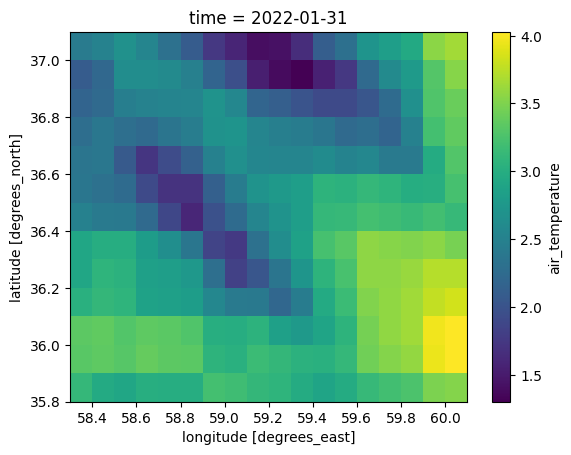

In [14]:
time_list = tmin['time'].values.astype(str).tolist()
ra = extraterrestrial_radiation(
    inverse_relative_distance_earth_sun = inverse_relative_distance_earth_sun(
        julian_date = standard_date_to_Julian_day (standard_date_in_gregorian = time_list[0])
    ),
    sunset_hour_angle = sunset_hour_angle(
        latitude=convert_degrees2radians(tmin.lat),
        solar_declination = solar_declination(
            julian_date = standard_date_to_Julian_day (standard_date_in_gregorian = time_list[0])
        )
    ),
    latitude = convert_degrees2radians(
        degrees = tmin.lat
    ),
    solar_declination = solar_declination(
        julian_date = standard_date_to_Julian_day (standard_date_in_gregorian = time_list[0])
    )
)

ET_hargreaves_samani = ReferenceEvapotranspiration.hargreaves_samani(
    tmin=tmin,
    tmax=tmax,
    tmean=tmean,
    ra=ra
)

ET_hargreaves_samani.air_temperature.plot()

### Estimate Reference Crop Evapotranspiration (ETo) Using the Penman Method.

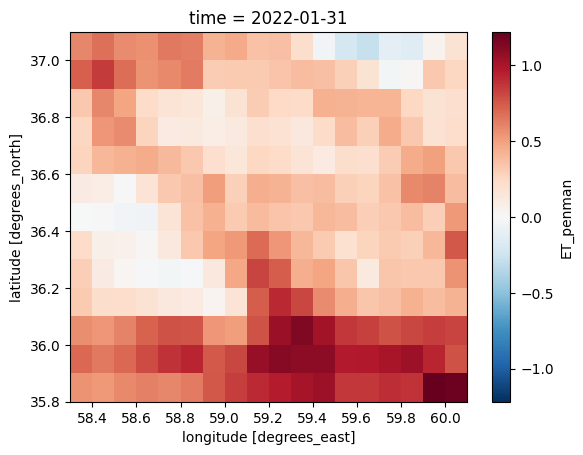

In [15]:
delta = slope_vapour_pressure_curve_with_maen_temperature(
    tmean = tmean.air_temperature
)

rn = (Rns.downward_shortwave_radiation - Rnl.downward_longwave_radiation) * 0.0864

G = SoilHeatFluxDensity.For_day_and_ten_day_periods()
gamma = psychrometric_constant_with_altitudes(pressure = (surface_pressure.surface_pressure) / 1000) 

es = total_saturation_vapour_pressure(
    saturated_vapor_pressure_at_maximum_temperature = saturation_vapour_pressure_with_temperature(
    temperature = tmax.air_temperature
    ),
    saturated_vapor_pressure_at_minimum_temperature = saturation_vapour_pressure_with_temperature(
    temperature = tmin.air_temperature
    )
)

ET_penman = ReferenceEvapotranspiration.fao56_penman_monteith(
    delta = delta,
    rn = rn,
    G = G,
    gamma = gamma,
    tmean = tmean.air_temperature,
    u2 = wind.wind_speed,
    es = es,
    ea = ActualVapourPressure.dew(
        tdew = tmin.air_temperature
    )
)

# Assuming you have a DataArray named ET_penman
ET_penman.name = 'ET_penman'

# Convert DataArray to Dataset
ET_penman_dataset = ET_penman.to_dataset()
ET_penman_dataset.ET_penman.plot()

### Estimate Reference Crop Evapotranspiration (ETo) Using pyet package and Penman Method.

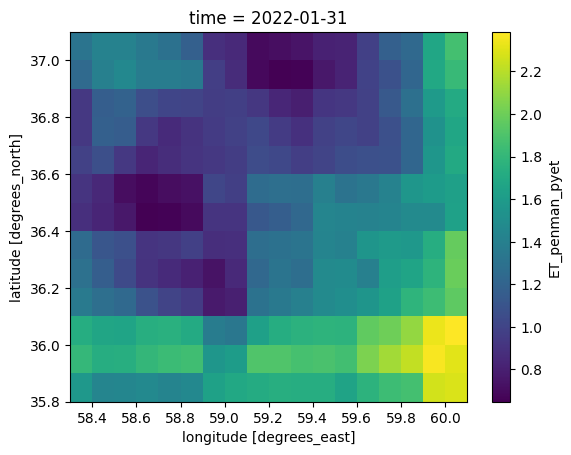

In [16]:
ET_pyet_penman = pyet.combination.pm_fao56(
    tmean = tmean.air_temperature,
    wind = wind.wind_speed,
    pressure = surface_pressure.surface_pressure,
    tmax = tmax.air_temperature,
    tmin = tmin.air_temperature,
    rn = rn,
    g = G,
    ea = ActualVapourPressure.dew(
        tdew = tmin.air_temperature
    ),
    lat = convert_degrees2radians(tmin.lat)
)
# Assuming you have a DataArray named ET_penman
ET_pyet_penman.name = 'ET_penman_pyet'

# Convert DataArray to Dataset
ET_pyet_penman_dataset = ET_pyet_penman.to_dataset()
ET_pyet_penman_dataset.ET_penman_pyet.plot()



### Estimate Reference Crop Evapotranspiration (ETo) Using pyet package and Hargreaves Method.

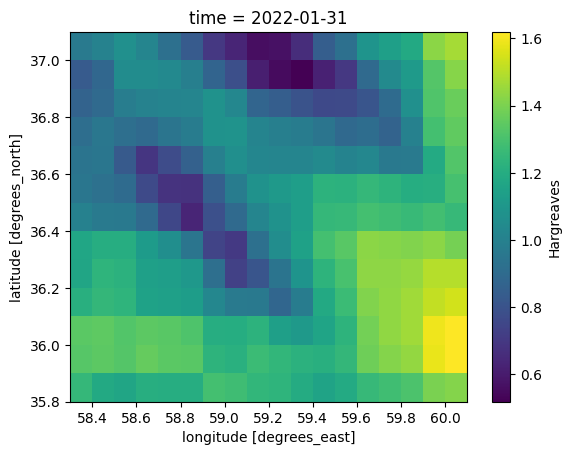

In [17]:
ET_pyet_hargreaves = pyet.combination.hargreaves(
    tmean = tmean.air_temperature, 
    tmax = tmax.air_temperature, 
    tmin = tmin.air_temperature, 
    lat = convert_degrees2radians(tmin.lat)
)
ET_pyet_hargreaves = ET_pyet_hargreaves.to_dataset()
ET_pyet_hargreaves.Hargreaves.plot()

### Estimate  Evapotranspiration (ET)

In [20]:
number_of_x = len(list(ET_pyet_hargreaves.lon.values.flatten()))
number_of_y = len(list(ET_pyet_hargreaves.lat.values.flatten()))


soil = list(xds_repr_match__soilmoisture.ssm.values.flatten())
sub_soil = list(xds_repr_match__sub_soilmoisture.susm.values.flatten())
soil_era = list(xds_repr_match__soil_era_evap_1.volumetric_soil_water_layer_1.values.flatten())

wp_list_10cm = list(map(lambda dict: dict['b10'], list_wp))
fc_list_10cm = list(map(lambda dict: dict['b10'], list_fc))

wp_list_100cm = list(map(lambda dict: dict['b100'], list_wp))
fc_list_100cm = list(map(lambda dict: dict['b100'], list_fc))

wp_list_200cm = list(map(lambda dict: dict['b200'], list_wp))
fc_list_200cm = list(map(lambda dict: dict['b200'], list_fc))

ET_hargreaves_list = list(ET_pyet_hargreaves.Hargreaves.values.flatten())



moisture_reduction = list(map(lambda x, y, z: moisture_reduction_function(
    soil_wetness_in_previous_step = x,
    permanent_wilting_point_wet = y,
    field_capacity_wet = z,
    soil_depth = 100), soil, wp_list_10cm, fc_list_10cm))

moisture_reduction_adjusted = list(map(lambda x: 0 if x < 0 else x, moisture_reduction))



ET_ca = list(map(lambda x, y : ActualEvapotranspiration.et_covered(
    moisture_reduction_function = x,
    crop_coefficient = 0.5,
    crop_cover = 0.4,
    reference_crop_evapotranspiration = y),
    moisture_reduction_adjusted, ET_hargreaves_list))


TE = list(map(lambda x, y : available_water(
    permanent_wilting_point_wet = x,
    field_capacity_wet = y,
    soil_depth = 100),wp_list_10cm, fc_list_10cm))


AE = 6 ## Assumption

K_e = list(map(lambda x : ratio_of_actual_evaporable_water_to_total_evaporable_water(
    available_water = x,
    available_evaporable_water = AE), TE))

E_a = list(map(lambda x, y : ActualEvapotranspiration.e_noncovered(
    ratio_of_actual_evaporable_water_to_total_evaporable_water = x,
    crop_cover = 0.4,
    reference_crop_evapotranspiration = y), K_e, ET_hargreaves_list))

ET_a = list(map(lambda x, y : ActualEvapotranspiration.et_QDWB(
    evaporation_noncovered_areas = x,
    evapotranspiration_covered_areas = y), E_a, ET_ca))

ET_ca_array = np.array(ET_ca)
E_a_array = np.array(E_a)
ET_a_array = np.array(ET_a)
wp_list_10cm_array = np.array(wp_list_10cm)
fc_list_10cm_array = np.array(fc_list_10cm)
wp_list_100cm_array = np.array(wp_list_100cm)
fc_list_100cm_array = np.array(fc_list_100cm)
wp_list_200cm_array = np.array(wp_list_200cm)
fc_list_200cm_array = np.array(fc_list_200cm)



ET_ca_array = ET_ca_array.reshape(1,number_of_y,number_of_x)
E_a_array = E_a_array.reshape(1,number_of_y,number_of_x)
ET_a_array = ET_a_array.reshape(1,number_of_y,number_of_x)
wp_list_10cm_array = wp_list_10cm_array.reshape(1,number_of_y,number_of_x)
fc_list_10cm_array = fc_list_10cm_array.reshape(1,number_of_y,number_of_x)
wp_list_100cm_array = wp_list_100cm_array.reshape(1,number_of_y,number_of_x)
fc_list_100cm_array = fc_list_100cm_array.reshape(1,number_of_y,number_of_x)
wp_list_200cm_array = wp_list_200cm_array.reshape(1,number_of_y,number_of_x)
fc_list_200cm_array = fc_list_200cm_array.reshape(1,number_of_y,number_of_x)


ds_array = tmin_renamed.assign(et_covered=(['time', 'y', 'x'], ET_ca_array))
ds_array_1 = ds_array.assign(e_noncovered=(['time', 'y', 'x'], E_a_array))
ds_array_2 = ds_array_1.assign(et_total=(['time', 'y', 'x'], ET_a_array))
ds_array_3 = ds_array_2.assign(wp_10cm=(['time', 'y', 'x'], wp_list_10cm_array))
ds_array_4 = ds_array_3.assign(fc_10cm=(['time', 'y', 'x'], fc_list_10cm_array))
ds_array_5 = ds_array_4.assign(wp_100cm=(['time', 'y', 'x'], wp_list_100cm_array))
ds_array_6 = ds_array_5.assign(fc_100cm=(['time', 'y', 'x'], fc_list_100cm_array))
ds_array_7 = ds_array_6.assign(wp_200cm=(['time', 'y', 'x'], wp_list_200cm_array))
ds_array_final = ds_array_7.assign(fc_200cm=(['time', 'y', 'x'], fc_list_200cm_array))

ds_array_final

<xarray.Dataset>
Dimensions:          (x: 18, y: 13, time: 1)
Coordinates:
  * x                (x) float32 58.35 58.45 58.55 58.65 ... 59.85 59.95 60.05
  * y                (y) float32 37.05 36.95 36.85 36.75 ... 36.05 35.95 35.85
  * time             (time) datetime64[ns] 2022-01-31
    spatial_ref      int64 0
Data variables:
    air_temperature  (time, y, x) float32 ...
    et_covered       (time, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    e_noncovered     (time, y, x) float64 0.2922 0.3212 0.3705 ... 0.495 0.5007
    et_total         (time, y, x) float64 0.2922 0.3212 0.3705 ... 0.495 0.5007
    wp_10cm          (time, y, x) float64 17.53 15.74 15.1 ... 15.14 13.31 13.31
    fc_10cm          (time, y, x) float64 29.45 26.98 25.45 ... 23.47 23.47
    wp_100cm         (time, y, x) float64 18.1 15.7 14.48 ... 15.71 13.87 13.87
    fc_100cm         (time, y, x) float64 29.57 26.18 24.51 ... 23.57 23.57
    wp_200cm         (time, y, x) float64 17.5 15.09 14.46 ... 15.11 13.26 13.26
    fc_200cm         (time, y, x) float64 28.87 25.25 24.1 ... 25.65 22.82 22.82
Attributes:
    history:          Created on 2022-02-06 07:16
    input_data_hash:  a1123a6e0d2788e1883ec8f01cc52110d92449cef4cf1591984fe91...

# for change crs from 4326 to 3857

In [ ]:

# Define the source and target CRS
source_crs = pyproj.CRS('EPSG:4326')
target_crs = pyproj.CRS('EPSG:3857')

# Create a coordinate transformer
transformer = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True)

# Reproject the data to the target CRS

ET_a_pyet_reprojected = ds_array_2.rio.write_crs("epsg:4326", inplace=True)
ET_a_pyet_reprojected = ET_a_pyet_reprojected.rio.reproject(target_crs, transformer=transformer)
ET_a_pyet_reprojected

<xarray.Dataset>
Dimensions:          (x: 17, y: 15, time: 1)
Coordinates:
  * x                (x) float64 6.496e+06 6.508e+06 ... 6.678e+06 6.69e+06
  * y                (y) float64 4.447e+06 4.435e+06 ... 4.289e+06 4.277e+06
  * time             (time) datetime64[ns] 2022-01-31
    spatial_ref      int64 0
Data variables:
    air_temperature  (time, y, x) float32 -7.312 -7.812 -6.875 ... -3.0 -2.875
    et_covered       (time, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    e_noncovered     (time, y, x) float64 0.2922 0.3212 0.3705 ... 0.495 0.5007
    et_total         (time, y, x) float64 0.2922 0.3212 0.3705 ... 0.495 0.5007
Attributes:
    history:          Created on 2022-02-06 07:16
    input_data_hash:  a1123a6e0d2788e1883ec8f01cc52110d92449cef4cf1591984fe91...

# clip xarray file by shape file

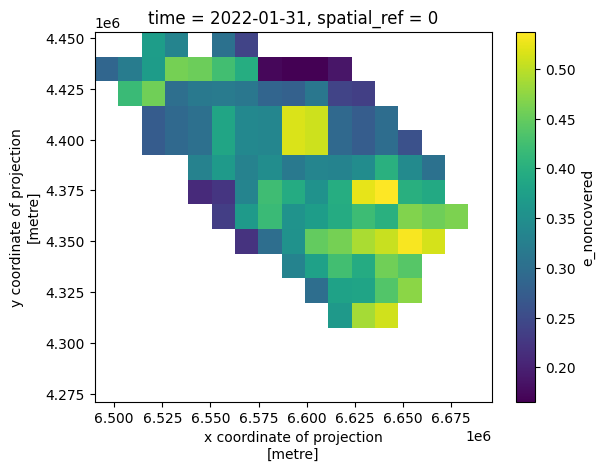

In [ ]:
# shp_dir = PATH_DATA + "/shape/usa.shp"
shp_dir = PATH_DATA + "/shape/mahdoode_mashhad.shp"
shp_dir_reprojected = PATH_DATA + "/shape/file_out.shp"

shapefile_reprojected = gpd.read_file(shp_dir_reprojected)
shapefile = gpd.read_file(shp_dir)


precip_da = add_shape_coord_from_data_array(ET_a_pyet_reprojected, shp_dir_reprojected, "shapefile_reprojected")
ET_a_pyet_reprojected = ET_a_pyet_reprojected.where(precip_da.shapefile_reprojected==0, other=np.nan)

precip_da_decimal = add_shape_coord_from_data_array(ds_array_2, shp_dir, "shapefile")
ds_array_2 = ds_array_2.where(precip_da_decimal.shapefile==0, other=np.nan)

ET_a_pyet_reprojected.e_noncovered.plot()


# save xarray as a pickle file

In [21]:
with open('/content/drive/MyDrive/WaterBalance_new/notebook/ET_hargreaves_mahdoode_mashhad_4326_pwp_and_fc.pkl', 'wb') as f:  # open a text file
    pickle.dump(ds_array_final, f) # serialize the list

# with open('/content/drive/MyDrive/WaterBalance_new/notebook/ETa_pyet_hargreaves_mahdoode_mashhad_3857.pkl', 'wb') as f:  # open a text file
#     pickle.dump(ET_a_pyet_reprojected, f) # serialize the list


# estimate crop data land

In [ ]:
# Specify the path to the GeoTIFF file
file_path_cdl = PATH_DATA + "/wyoming/cdl_wyoming.tif"

geotiff_da = xr.open_rasterio(file_path_cdl)


geotiff_da.name = 'cdl'

# Convert DataArray to Dataset
geotiff_da_dataset = geotiff_da.to_dataset()
# ET_pyet_penman_dataset.ET_penman_pyet.plot()
geotiff_da_dataset

<ipython-input-21-530ed54fbde3>:4: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  geotiff_da = xr.open_rasterio(file_path_cdl)


<xarray.Dataset>
Dimensions:  (band: 1, y: 3865, x: 4608)
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 5.539e+06 5.538e+06 5.538e+06 ... 5.379e+06 5.379e+06
  * x        (x) float64 -1.216e+07 -1.216e+07 ... -1.197e+07 -1.197e+07
Data variables:
    cdl      (band, y, x) uint8 ...

In [ ]:

# Open the GeoTIFF file
dataset = gdal.Open(file_path_cdl)

band = dataset.GetRasterBand(1)  # Get the first band

pixels = band.ReadAsArray()


pixels_array = pixels.reshape(1,len(list(geotiff_da_dataset.y.values.flatten())),len(list(geotiff_da_dataset.x.values.flatten())))


ds_array_cdl = geotiff_da_dataset.assign(cdl=(['time', 'y', 'x'], pixels_array))
ds_array_cdl

<xarray.Dataset>
Dimensions:  (band: 1, y: 3865, x: 4608, time: 1)
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 5.539e+06 5.538e+06 5.538e+06 ... 5.379e+06 5.379e+06
  * x        (x) float64 -1.216e+07 -1.216e+07 ... -1.197e+07 -1.197e+07
Dimensions without coordinates: time
Data variables:
    cdl      (time, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0

In [ ]:
df = pd.read_excel(PATH_DATA + "/cdl_table.xlsx", sheet_name = "Sheet2", header = 0)


# df['Concatenated'] = df["Value"].astype(str) + ":" + df["Description"].astype(str)


# Creating a dictionary from a column
column_name = 'Value'  # Specify the column name

dictionary = df.set_index(column_name).to_dict()['Description']
dictionary

{1: 'Corn',
 2: 'Cotton',
 3: 'Rice',
 4: 'Sorghum',
 5: 'Soybeans',
 6: 'Sunflower',
 10: 'Peanuts',
 11: 'Tobacco',
 12: 'Sweet Corn',
 13: 'Pop or Orn Corn',
 14: 'Mint',
 21: 'Barley',
 22: 'Durum Wheat',
 23: 'Spring Wheat',
 24: 'Winter Wheat',
 25: 'Other Small Grains',
 26: 'Dbl Crop WinWht/Soybeans',
 27: 'Rye',
 28: 'Oats',
 29: 'Millet',
 30: 'Speltz',
 31: 'Canola',
 32: 'Flaxseed',
 33: 'Safflower',
 34: 'Rape Seed',
 35: 'Mustard',
 36: 'Alfalfa',
 37: 'Other Hay/Non Alfalfa',
 38: 'Camelina',
 39: 'Buckwheat',
 41: 'Sugarbeets',
 42: 'Dry Beans',
 43: 'Potatoes',
 44: 'Other Crops',
 45: 'Sugarcane',
 46: 'Sweet Potatoes',
 47: 'Misc Vegs & Fruits',
 48: 'Watermelons',
 49: 'Onions',
 50: 'Cucumbers',
 51: 'Chick Peas',
 52: 'Lentils',
 53: 'Peas',
 54: 'Tomatoes',
 55: 'Caneberries',
 56: 'Hops',
 57: 'Herbs',
 58: 'Clover/Wildflowers',
 59: 'Sod/Grass Seed',
 60: 'Switchgrass',
 61: 'Fallow/Idle Cropland',
 63: 'Forest',
 64: 'Shrubland',
 65: 'Barren',
 66: 'Cherries'

### vlookup key's dictionary in a xarray and save value of dictionary as a data variable in xarray



In [ ]:
# Perform the VLOOKUP-like operation
lookup_func = np.vectorize(lambda key: dictionary.get(key, ''))
new_data = xr.apply_ufunc(lookup_func, ds_array_cdl.cdl)




# Add the new data variable to the xarray dataset
ds_array_cdl['crop'] = new_data


df = ds_array_cdl.to_dataframe()

# Save the DataFrame to an Excel file
df.to_csv(PATH_DATA + "/cdl_wyoming.csv", index=False)

In [ ]:
import geemap

Map = geemap.Map()
Map.add_basemap('HYBRID')

shape = ee.FeatureCollection('projects/ee-mohammadnejadmehdi77/assets/sample_usa')
# shape = ee.Geometry.Rectangle([LON_MAX,LAT_MIN,LON_MIN,LAT_MAX])
# LAT_MIN = 43.30
# LAT_MAX = 44.60
# LON_MIN = -109.40
# LON_MAX = -107.40

CDL = ee.ImageCollection("USDA/NASS/CDL")

# Crop Mask selection

cropland = CDL.filterDate('2021-01-01','2021-12-30').select('cropland').filterBounds(shape).first().clip(shape)
 
Map.centerObject(shape, 9)
Map.addLayer(cropland, {}, 'cropland')
Map

Map(center=[43.88531410627492, -108.32657408653418], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
cropland = cropland.set("system:time_start", ee.Date("2021"))
arr_cropland = cropland.wx.to_xarray(scale=1000, crs='EPSG:4326')



EEException: ignored

In [ ]:
from osgeo import gdal
import numpy as np
from pystac.extensions.raster import DataType, RasterBand
from typing import Type, TypeVar
from enum import Enum

T = TypeVar("T", bound="StrEnum")


class StrEnum(str, Enum):
    """A string-based enum, that can lookup an enum value from a string."""

    @classmethod
    def from_str(cls: Type[T], s: str) -> T:
        """Look up an enum value by string."""
        for value in cls:
            if value == s:
                return value
        raise ValueError(f"Could not parse value from string: {s}")

class AssetType(StrEnum):
    """The type of USDA CDL asset.
    The source data use "cdl" instead of "cropland", but we think "cropland" is
    more descriptive and less confusing.
    """

    Cropland = "cropland"
    Confidence = "confidence"
    Cultivated = "cultivated"
    Corn = "corn"
    Cotton = "cotton"
    Soybeans = "soybeans"
    Wheat = "wheat"

    def is_frequency(self) -> bool:
        """Is this asset part of the "frequency" data?"""
        return (
            self == AssetType.Corn
            or self == AssetType.Cotton
            or self == AssetType.Soybeans
            or self == AssetType.Wheat
        )


CLASSIFICATION_SCHEMA = (
    "https://stac-extensions.github.io/classification/v1.1.0/schema.json"
)
COG_TITLES = {
    AssetType.Cropland: "Cropland Data Layer (CDL)",
    AssetType.Confidence: "Confidence",
    AssetType.Cultivated: "Cultivated",
    AssetType.Corn: "Corn",
    AssetType.Cotton: "Cotton",
    AssetType.Soybeans: "Soybeans",
    AssetType.Wheat: "Wheat",
}
COG_RASTER_BAND = {
    AssetType.Cropland: RasterBand.create(
        spatial_resolution=30, nodata=0, data_type=DataType.UINT8
    ),
    AssetType.Confidence: RasterBand.create(
        spatial_resolution=30, nodata=0, data_type=DataType.UINT8
    ),
    AssetType.Cultivated: RasterBand.create(
        spatial_resolution=30, nodata=0, data_type=DataType.UINT8
    ),
    AssetType.Corn: RasterBand.create(
        spatial_resolution=30, nodata=255, data_type=DataType.UINT8
    ),
    AssetType.Cotton: RasterBand.create(
        spatial_resolution=30, nodata=255, data_type=DataType.UINT8
    ),
    AssetType.Soybeans: RasterBand.create(
        spatial_resolution=30, nodata=255, data_type=DataType.UINT8
    ),
    AssetType.Wheat: RasterBand.create(
        spatial_resolution=30, nodata=255, data_type=DataType.UINT8
    ),
}

ASSET_CLASSES = {
    AssetType.Cropland: [
        {"value": 1, "description": "Corn", "color_hint": "FFD200"},
        {"value": 2, "description": "Cotton", "color_hint": "FF2525"},
        {"value": 3, "description": "Rice", "color_hint": "00A8E3"},
        {"value": 4, "description": "Sorghum", "color_hint": "FF9E0A"},
        {"value": 5, "description": "Soybeans", "color_hint": "256F00"},
        {"value": 6, "description": "Sunflower", "color_hint": "FFFF00"},
        {"value": 10, "description": "Peanuts", "color_hint": "6FA400"},
        {"value": 11, "description": "Tobacco", "color_hint": "00AE4A"},
        {"value": 12, "description": "Sweet Corn", "color_hint": "DDA40A"},
        {"value": 13, "description": "Pop or Orn Corn", "color_hint": "DDA40A"},
        {"value": 14, "description": "Mint", "color_hint": "7DD2FF"},
        {"value": 21, "description": "Barley", "color_hint": "E1007B"},
        {"value": 22, "description": "Durum Wheat", "color_hint": "886153"},
        {"value": 23, "description": "Spring Wheat", "color_hint": "D7B56B"},
        {"value": 24, "description": "Winter Wheat", "color_hint": "A46F00"},
        {"value": 25, "description": "Other Small Grains", "color_hint": "D59EBB"},
        {"value": 26,"description": "Winter Wheat/Soybeans","color_hint": "6F6F00"},
        {"value": 27, "description": "Rye", "color_hint": "AC007B"},
        {"value": 28, "description": "Oats", "color_hint": "9F5888"},
        {"value": 29, "description": "Millet", "color_hint": "6F0048"},
        {"value": 30, "description": "Speltz", "color_hint": "D59EBB"},
        {"value": 31, "description": "Canola", "color_hint": "D1FF00"},
        {"value": 32, "description": "Flaxseed", "color_hint": "7D99FF"},
        {"value": 33, "description": "Safflower", "color_hint": "D5D500"},
        {"value": 34, "description": "Rape Seed", "color_hint": "D1FF00"},
        {"value": 35, "description": "Mustard", "color_hint": "00AE4A"},
        {"value": 36, "description": "Alfalfa", "color_hint": "FFA4E1"},
        {"value": 37,"description": "Other Hay/Non Alfalfa","color_hint": "A4F18B"},
        {"value": 38, "description": "Camelina", "color_hint": "00AE4A"},
        {"value": 39, "description": "Buckwheat", "color_hint": "D59EBB"},
        {"value": 41, "description": "Sugarbeets", "color_hint": "A800E3"},
        {"value": 42, "description": "Dry Beans", "color_hint": "A40000"},
        {"value": 43, "description": "Potatoes", "color_hint": "6F2500"},
        {"value": 44, "description": "Other Crops", "color_hint": "00AE4A"},
        {"value": 45, "description": "Sugarcane", "color_hint": "B07DFF"},
        {"value": 46, "description": "Sweet Potatoes", "color_hint": "6F2500"},
        {"value": 47, "description": "Misc. Vegs & Fruits", "color_hint": "FF6666"},
        {"value": 48, "description": "Watermelons", "color_hint": "FF6666"},
        {"value": 49, "description": "Onions", "color_hint": "FFCC66"},
        {"value": 50, "description": "Cucumbers", "color_hint": "FF6666"},
        {"value": 51, "description": "Chick Peas", "color_hint": "00AE4A"},
        {"value": 52, "description": "Lentils", "color_hint": "00DDAE"},
        {"value": 53, "description": "Peas", "color_hint": "53FF00"},
        {"value": 54, "description": "Tomatoes", "color_hint": "F1A277"},
        {"value": 55, "description": "Caneberries", "color_hint": "FF6666"},
        {"value": 56, "description": "Hops", "color_hint": "00AE4A"},
        {"value": 57, "description": "Herbs", "color_hint": "7DD2FF"},
        {"value": 58, "description": "Clover/Wildflowers", "color_hint": "E8BEFF"},
        {"value": 59, "description": "Sod/Grass Seed", "color_hint": "AEFFDD"},
        {"value": 60, "description": "Switchgrass", "color_hint": "00AE4A"},
        {"value": 61,"description": "Fallow/Idle Cropland","color_hint": "BEBE77"},
        {"value": 63, "description": "Forest", "color_hint": "92CC92"},
        {"value": 64, "description": "Shrubland", "color_hint": "C5D59E"},
        {"value": 65, "description": "Barren", "color_hint": "CCBEA2"},
        {"value": 66, "description": "Cherries", "color_hint": "FF00FF"},
        {"value": 67, "description": "Peaches", "color_hint": "FF8EAA"},
        {"value": 68, "description": "Apples", "color_hint": "B9004F"},
        {"value": 69, "description": "Grapes", "color_hint": "6F4488"},
        {"value": 70, "description": "Christmas Trees", "color_hint": "007777"},
        {"value": 71, "description": "Other Tree Crops", "color_hint": "B09A6F"},
        {"value": 72, "description": "Citrus", "color_hint": "FFFF7D"},
        {"value": 74, "description": "Pecans", "color_hint": "B56F5B"},
        {"value": 75, "description": "Almonds", "color_hint": "00A482"},
        {"value": 76, "description": "Walnuts", "color_hint": "E9D5AE"},
        {"value": 77, "description": "Pears", "color_hint": "B09A6F"},
        {"value": 81, "description": "Clouds/No Data", "color_hint": "F1F1F1"},
        {"value": 82, "description": "Developed", "color_hint": "9A9A9A"},
        {"value": 83, "description": "Water", "color_hint": "4A6fA2"},
        {"value": 87, "description": "Wetlands", "color_hint": "7DB0B0"},
        {"value": 88, "description": "Nonag/Undefined", "color_hint": "E8FFBE"},
        {"value": 92, "description": "Aquaculture", "color_hint": "00FFFF"},
        {"value": 111, "description": "Open Water", "color_hint": "4A6FA2"},
        {"value": 112, "description": "Perennial Ice/Snow", "color_hint": "D2E1F8"},
        {"value": 121,"description": "Developed/Open Space","color_hint": "9A9A9A"},
        {"value": 122,"description": "Developed/Low Intensity", "color_hint": "9A9A9A"},
        {"value": 123, "description": "Developed/Med Intensity","color_hint": "9A9A9A"},
        {"value": 124,"description": "Developed/High Intensity","color_hint": "9A9A9A"},
        {"value": 131, "description": "Barren", "color_hint": "CCBEA2"},
        {"value": 141, "description": "Deciduous Forest", "color_hint": "92CC92"},
        {"value": 142, "description": "Evergreen Forest", "color_hint": "92CC92"},
        {"value": 143, "description": "Mixed Forest", "color_hint": "92CC92"},
        {"value": 152, "description": "Shrubland", "color_hint": "C5D59E"},
        {"value": 176, "description": "Grassland/Pasture", "color_hint": "E8FFBE"},
        {"value": 190, "description": "Woody Wetlands", "color_hint": "7DB0B0"},
        {"value": 195,"description": "Herbaceous Wetlands","color_hint": "7DB0B0"},
        {"value": 204, "description": "Pistachios", "color_hint": "00FF8B"},
        {"value": 205, "description": "Triticale", "color_hint": "D59EBB"},
        {"value": 206, "description": "Carrots", "color_hint": "FF6666"},
        {"value": 207, "description": "Asparagus", "color_hint": "FF6666"},
        {"value": 208, "description": "Garlic", "color_hint": "FF6666"},
        {"value": 209, "description": "Cantaloupes", "color_hint": "FF6666"},
        {"value": 210, "description": "Prunes", "color_hint": "FF8EAA"},
        {"value": 211, "description": "Olives", "color_hint": "334833"},
        {"value": 212, "description": "Oranges", "color_hint": "E36F25"},
        {"value": 213, "description": "Honeydew Melons", "color_hint": "FF6666"},
        {"value": 214, "description": "Broccoli", "color_hint": "FF6666"},
        {"value": 215, "description": "Avocados", "color_hint": "66994B"},
        {"value": 216, "description": "Peppers", "color_hint": "FF6666"},
        {"value": 217, "description": "Pomegranates", "color_hint": "B09A6F"},
        {"value": 218, "description": "Nectarines", "color_hint": "FF8EAA"},
        {"value": 219, "description": "Greens", "color_hint": "FF6666"},
        {"value": 220, "description": "Plums", "color_hint": "FF8EAA"},
        {"value": 221, "description": "Strawberreis", "color_hint": "FF6666"},
        {"value": 222, "description": "Squash", "color_hint": "FF6666"},
        {"value": 223, "description": "Apricots", "color_hint": "FF8EAA"},
        {"value": 224, "description": "Vetch", "color_hint": "00AE4A"},
        {"value": 225, "description": "Winter Wheat/Corn", "color_hint": "FFD200"},
        {"value": 226, "description": "Oats/Corn", "color_hint": "FFD200"},
        {"value": 227, "description": "Lettuce", "color_hint": "FF6666"},
        {"value": 228, "description": "Triticale/Corn", "color_hint": "FF6666"},
        {"value": 229, "description": "Pumpkins", "color_hint": "FF6666"},
        {"value": 230,"description": "Lettuce/Durum Wheat","color_hint": "886153"},
        {"value": 231, "description": "Lettuce/Cataloupe", "color_hint": "FF6666"},
        {"value": 232, "description": "Lettuce/Cotton", "color_hint": "FF2525"},
        {"value": 233, "description": "Lettuce/Barley", "color_hint": "A1007B"},
        {"value": 234,"description": "Durum Wheat/Sorghum","color_hint": "FF9E0A"},
        {"value": 235, "description": "Barley/Sorghum", "color_hint": "FF9E0A"},
        {"value": 236,"description": "Winter Wheat/Sorghum","color_hint": "A46F00"},
        {"value": 237, "description": "Barley/Corn", "color_hint": "FFD200"},
        {"value": 238,"description": "Winter Wheat/Cotton","color_hint": "A46F00"},
        {"value": 239, "description": "Soybeans/Cotton", "color_hint": "256F00"},
        {"value": 240, "description": "Soybeans/Oats ", "color_hint": "256F00"},
        {"value": 241, "description": "Corn/Soybeans", "color_hint": "FFD200"},
        {"value": 242, "description": "Blueberries", "color_hint": "000099"},
        {"value": 243, "description": "Cabbage", "color_hint": "FF6666"},
        {"value": 244, "description": "Cauliflower", "color_hint": "FF6666"},
        {"value": 245, "description": "Celery", "color_hint": "FF6666"},
        {"value": 246, "description": "Radishes", "color_hint": "FF6666"},
        {"value": 247, "description": "Turnips", "color_hint": "FF6666"},
        {"value": 248, "description": "Eggplants", "color_hint": "FF6666"},
        {"value": 249, "description": "Gourds", "color_hint": "FF6666"},
        {"value": 250, "description": "Cranberries", "color_hint": "FF6666"},
        {"value": 254, "description": "Barley/Soybeans", "color_hint": "256F00"}
        ],
        AssetType.Cultivated: [
        {"value": 1, "description": "Non-Cultivated", "color_hint": "000000"},
        {"value": 2, "description": "Cultivated", "color_hint": "006300"},
    ],
}

# Open the tif file
ds = gdal.Open('/mnt/e/Term2/payan_name/export/et/clipped.TIF')

# Get the number of bands
num_bands = ds.RasterCount

# Create an empty dictionary
classification_dict = {}

# Loop over each band and get the unique values and their counts
for band_num in range(1, num_bands+1):
    band = ds.GetRasterBand(band_num)
    values = band.ReadAsArray()
    unique_values, value_counts = np.unique(values, return_counts=True)
    classification_dict = dict(zip(unique_values, value_counts))

# Print the resulting dictionary
print(classification_dict)


## calculate ET with Ameriflux data

In [ ]:
import datetime
import pandas as pd
import dask.dataframe as dd
from xlsx2csv import Xlsx2csv

station = "US-Wkg"
start_timestamp = '2007-06-29 13:15:00'
end_timestamp = '2022-07-29 03:45:00'

path_ameri = '/mnt/e/Term2/payan_name/import/ameriflux_twobasins/'

Xlsx2csv(path_ameri + f"stations_Arizona/{station}.xlsx", outputencoding="utf-8").convert(path_ameri + f"stations_Arizona/csv/{station}.csv")

def dateparse(x): return datetime.datetime.strptime(
    x, "%Y-%m-%d %H:%m:%s").strftime("%Y-%m-%d %H:%m:%s")


US_Whs = dd.read_csv(path_ameri + f"stations_Arizona/csv/{station}.csv")  
# US_Whs = pd.read_excel(path_ameri + "stations_Arizona/US-Whs.xlsx", sheet_name='Sheet 1', header=0, parse_dates=['TIMESTAMP'],)
US_Whs = US_Whs.compute()


US_Whs['TIMESTAMP'] = pd.to_datetime(US_Whs['TIMESTAMP'])

filtered_df = US_Whs.loc[(US_Whs['TIMESTAMP'] >= start_timestamp) & (US_Whs['TIMESTAMP'] <= end_timestamp)]
# filtered_df = US_Whs.query('@start_timestamp<=TIMESTAMP<=@end_timestamp')

US_Whs['landa_E'] = 2.051 - (0.002361* filtered_df['TA_1_1_1'])
US_Whs['ET_ameri'] = (filtered_df['NETRAD']- filtered_df['G'] - filtered_df['H']) / US_Whs['landa_E']

US_Whs.to_csv(path_ameri + f"stations_Arizona/csv/{station}.csv", index=False)